In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# simple autoencoder pca equivalent
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss='mse', optimizer=optimizer)

In [13]:
tf.random.set_seed(42)

# stacked autoencoder
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_autoencoder = tf.keras.Sequential([stacked_encoder, stacked_decoder])
stacked_autoencoder.compile(loss='mse', optimizer='nadam')

In [3]:
# fashion mnist dataset
fm_dataset = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fm_dataset
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [15]:
history = stacked_autoencoder.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0348 - val_loss: 0.0187
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0179 - val_loss: 0.0170
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0166 - val_loss: 0.0164
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0159 - val_loss: 0.0157
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0149 - val_loss: 0.0149
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0144 - val_loss: 0.0146
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0142 - val_loss: 0.0145
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0140 - val_loss: 0.0143
Epoch 12/20
1719/1719 

In [16]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index)
        plt.imshow(images[image_index], cmap='binary')
        plt.axis('off')
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap='binary')
        plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


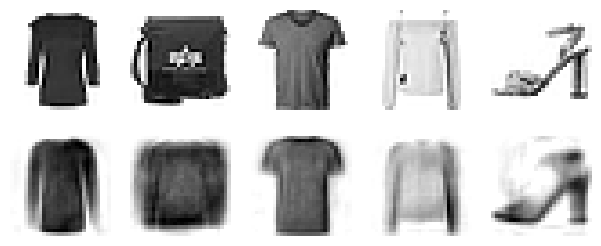

In [17]:
plot_reconstructions(stacked_autoencoder)
plt.show()

In [19]:
# tying weights
# layer using transposed weights of other layer
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias', shape=[self.dense.input.shape[-1]], initializer='zeros')

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [20]:
dense_1 = tf.keras.layers.Dense(100, activation='relu')
dense_2 = tf.keras.layers.Dense(30, activation='relu')
tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])
tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense=dense_2, activation='relu'),
    DenseTranspose(dense=dense_1),
    tf.keras.layers.Reshape([28, 28])
])
tied_autoencoder = tf.keras.Sequential([
    tied_encoder,
    tied_decoder
])
tied_autoencoder.compile(loss='mse', optimizer='nadam')

In [21]:
history = tied_autoencoder.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20


I0000 00:00:1727871450.629508   91014 service.cc:146] XLA service 0x7ff2f0004be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727871450.629580   91014 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6


  44/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1322   

I0000 00:00:1727871461.143175   91014 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - loss: 0.0341 - val_loss: 0.0167
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0162 - val_loss: 0.0152
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0150 - val_loss: 0.0147
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0145 - val_loss: 0.0143
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0141 - val_loss: 0.0144
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0139 - val_loss: 0.0139
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0134 - val_loss: 0.0137
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0133 - val_loss: 0.0134
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0132 - val_loss: 0.0135
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0131 - val_loss: 0.0145
Epoch 12/20
1719/1719 ━━━━━━━━━━━━━━━━

In [4]:
# variational autoencoders (VAE)
# drawing samples from gaussian distribution with given mean and logarithm of variance
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, variance_log = inputs
        return tf.random.normal(tf.shape(variance_log)) * tf.exp(variance_log / 2) + mean

In [12]:
# loss function
class KLDivergenceLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(KLDivergenceLayer, self).__init__(**kwargs)

    def call(self, codings_mean, codings_variance_log):
        # KL divergence loss
        latent_loss = -0.5 * tf.reduce_sum(
            1 + codings_variance_log - tf.exp(codings_variance_log) - tf.square(codings_mean),
            axis=-1
        )
        # Add the loss to the layer
        self.add_loss(tf.reduce_mean(latent_loss) / 784.)
        return codings_mean, codings_variance_log

In [14]:
codings_size = 10

# encoder
inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation='relu')(Z)
Z = tf.keras.layers.Dense(100, activation='relu')(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)
codings_variance_log = tf.keras.layers.Dense(codings_size)(Z)
codings_mean, codings_variance_log = KLDivergenceLayer()(codings_mean, codings_variance_log)
codings = Sampling()([codings_mean, codings_variance_log])
variational_encoder = tf.keras.Model(
    inputs=[inputs],
    outputs=[codings_mean, codings_variance_log, codings]
)

# decoder
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
X = tf.keras.layers.Dense(100, activation='relu')(decoder_inputs)
X = tf.keras.layers.Dense(150, activation='relu')(X)
X = tf.keras.layers.Dense(28*28, activation='sigmoid')(X)
outputs = tf.keras.layers.Reshape([28,28])(X)
variational_decoder = tf.keras.Model(
    inputs=[decoder_inputs],
    outputs=[outputs]
)

In [15]:
# VAE model
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
vae_model = tf.keras.Model(
    inputs=[inputs],
    outputs=[reconstructions]
)

In [16]:
vae_model.compile(loss='mse', optimizer='nadam')
history = vae_model.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=(X_valid, X_valid))

Epoch 1/25


I0000 00:00:1727949488.039496   35465 service.cc:146] XLA service 0x7fb948010550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727949488.039878   35465 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6


 24/430 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1546

I0000 00:00:1727949510.130796   35465 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


430/430 ━━━━━━━━━━━━━━━━━━━━ 58s 76ms/step - loss: 0.0755 - val_loss: 0.0397
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0380 - val_loss: 0.0363
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0353 - val_loss: 0.0348
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0342 - val_loss: 0.0338
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0333 - val_loss: 0.0334
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0330 - val_loss: 0.0331
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0325 - val_loss: 0.0324
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0322 - val_loss: 0.0322
Epoch 9/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0319 - val_loss: 0.0321
Epoch 10/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0318 - val_loss: 0.0319
Epoch 11/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0315 - val_loss: 0.0316
Epoch 12/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 